# DenseNet implementation with PyTorch

In [1]:
# import librairies

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time

In [2]:
# Device configuration
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
cuda:0


In [3]:
# Define train and test dataset
batch_size = 64

# Dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'airplane')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

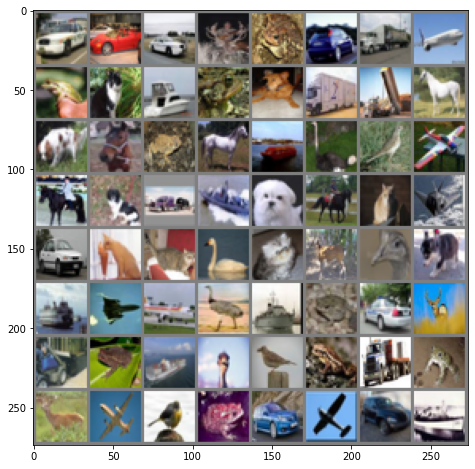

In [6]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

In [7]:
""" From the paper
Bottleneck layers: Although each layer only produces k output feature-maps, 
it typically has many more inputs. It has been noted that a 1x1 convolution 
can be introduced as bottleneck layer before each 3x3 convolution to reduce 
the number of input feature-maps, and thus to improve computational efficiency.
We find this design especially effective for DenseNet and we refer to our 
network with such a bottleneck layer, i.e., 
to the BN-ReLU-Conv(1x1)->BN-ReLU-Conv(3x3) version of H_l, as DenseNet-B 
"""

class Bottleneck(nn.Module):
  def __init__(self, input_channel, growth_rate):
    super(Bottleneck, self).__init__()
    # From the paper we let each 1×1 convolution produce 4k feature-maps
    inner_channel = 4 * growth_rate

    # bottleneck layer --> BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3)
    self.bottleneck = nn.Sequential(
        nn.BatchNorm2d(input_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(input_channel, inner_channel, kernel_size=1, bias=False),
        nn.BatchNorm2d(inner_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
    )

  def forward(self, x):
    return torch.cat([x, self.bottleneck(x)], 1)

In [8]:
""" From the paper
We refer to layers between blocks as transition layers, which do convolution
and pooling. The transition layers used in our experiments  consist of a 
batch normalization layer and an 1×1 conv layer followed by a 2×2 average 
pooling layer.
"""

class Transition(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(Transition, self).__init__()
    # BN-Con(1x1)-AvgPool(2x2)
    self.reduce_feature_maps = nn.Sequential(
        nn.BatchNorm2d(input_channel),
        nn.Conv2d(input_channel, output_channel, 1, bias=False),
        nn.AvgPool2d(2, stride=2)
    )
  
  def forward(self, x):
    return self.reduce_feature_maps(x)

In [9]:
# DenseNet class

class DenseNet(nn.Module):
  def __init__(self, block, num_block, growth_rate=12, theta=0.5, num_classes=10):
    super(DenseNet, self).__init__()
    self.growth_rate = growth_rate

    # Before entering the first dense block, a convolution with 16 (or twice the 
    # growth rate for DenseNet-BC) output channels is performed on the input images.
    inner_channels = 2 * growth_rate

    # For convolutional layers with kernel size 3×3, each side of the inputs is
    # zero-padded by one pixel to keep the feature-map size fixed.
    self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)
    self.features = nn.Sequential()

    for index in range(len(num_block) - 1):
      self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, num_block[index]))
      inner_channels += growth_rate * num_block[index]

      # If a dense block contains m feature-maps, we let the following transition 
      # layer generate θm output feature-maps, where 0 < θ ≤ 1 is referred to as 
      # the compression factor.
      output_channel = int(theta * inner_channels) 
      self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, output_channel))
      inner_channels = output_channel

    self.features.add_module("dense_block{}".format(len(num_block) - 1), self._make_dense_layers(block, inner_channels, num_block[len(num_block)-1]))
    inner_channels += growth_rate * num_block[len(num_block) - 1]
    self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
    self.features.add_module('activation', nn.ReLU(inplace=True))

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(inner_channels, num_classes)

  def forward(self, x):
      output = self.conv1(x)
      output = self.features(output)
      output = self.avgpool(output)
      output = output.view(output.size()[0], -1)
      output = self.linear(output)
      return output

  def _make_dense_layers(self, block, input_channel, num_block):
      dense_block = nn.Sequential()
      for index in range(num_block):
          dense_block.add_module('bottleneck_layer_{}'.format(index), block(input_channel, self.growth_rate))
          input_channel += self.growth_rate
      return dense_block

In [10]:
# Define multiple DenseNets for different architecture

def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet264(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,64,48], growth_rate=48)

In [11]:
# Hyper-parameters
batch_size = 64
learning_rate = 0.1
momentum = 0.9
num_epoch = 40

In [12]:
model_1 = densenet121()
model_2 = densenet169()
model_3 = densenet201()
model_4 = densenet264()

In [13]:
# Set model to device
model_1.to(device)

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(num_epoch * 0.5), int(num_epoch * 0.75)], gamma=0.1, last_epoch=-1)

In [14]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy']) 

In [16]:
# Training model
running_loss = 0
for epoch in range(1, num_epoch+1):
  lr_scheduler.step()
    
  start_time = time.time()
  
  train_accuracy = 0
  for inputs, labels in train_loader:
      # Move input and label tensors to the default device
      inputs, labels = inputs.to(device), labels.to(device)
       
      # Forward pass
      log_ps = model_1.forward(inputs)
      loss = criterion(log_ps, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      
      # Train accuracy
      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      
      
  end_time = time.time()

  # Model evaluation 
  
  test_loss = 0
  test_accuracy = 0
  model_1.eval()
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          log_ps = model_1.forward(inputs)
          batch_loss = criterion(log_ps, labels)

          test_loss += batch_loss.item()

          # Test  accuracy
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

  
  end_start_time = (end_time-start_time)/60
  print()
  print(f"Epoch {epoch}/{num_epoch} || "
        f"Time per epoch: {end_start_time :.2f} minutes || "
        f"Train loss: {100 *(running_loss/len(train_loader)):.2f} % || "
        f"Train accuracy: {100 * (train_accuracy/len(train_loader)):.2f} % || "
        f"Test loss: {100 * (test_loss/len(test_loader)):.2f} % || "
        f"Test accuracy: {100 * (test_accuracy/len(test_loader)):.2f} % ")
  print("----------"*14)

  train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':end_start_time, 'Train loss' : running_loss/len(train_loader), 
                                    'Train accuracy': train_accuracy/len(train_loader), 'Test loss' : test_loss/len(test_loader),
                                    'Test accuracy': test_accuracy/len(test_loader)}, ignore_index=True)

  running_loss = 0


Epoch 1/40 || Time per epoch: 3.30 minutes || Train loss: 153.15 % || Train accuracy: 43.90 % || Test loss: 125.30 % || Test accuracy: 54.79 % 
--------------------------------------------------------------------------------------------------------------------------------------------

Epoch 2/40 || Time per epoch: 3.23 minutes || Train loss: 122.28 % || Train accuracy: 55.93 % || Test loss: 114.44 % || Test accuracy: 59.12 % 
--------------------------------------------------------------------------------------------------------------------------------------------

Epoch 3/40 || Time per epoch: 3.23 minutes || Train loss: 101.61 % || Train accuracy: 63.77 % || Test loss: 101.76 % || Test accuracy: 63.80 % 
--------------------------------------------------------------------------------------------------------------------------------------------

Epoch 4/40 || Time per epoch: 3.23 minutes || Train loss: 87.57 % || Train accuracy: 68.88 % || Test loss: 90.33 % || Test accuracy: 67.86 % 

In [17]:
train_stats.to_csv('train_log_DenseNet121.csv')

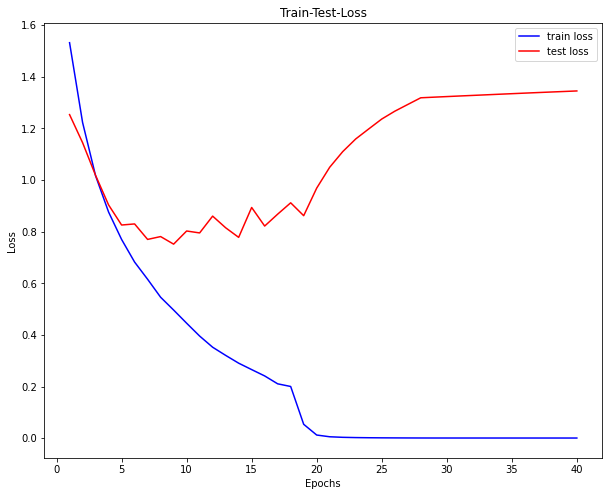

In [18]:
# Graph for training and test loss

fig = plt.figure(figsize=(10,8))
ax = plt.axes()

plt.title("Train-Test-Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-b', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-r', label='test loss');

plt.legend()
plt.savefig("training_train_loss.png", dpi = 300) 

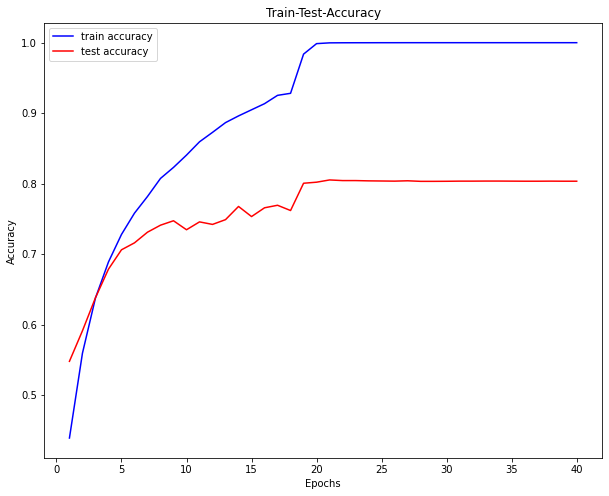

In [19]:
# Graph for training and test accuracy

fig = plt.figure(figsize=(10,8))
ax = plt.axes()

plt.title("Train-Test-Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-b', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-r', label='test accuracy');

plt.legend()
plt.savefig("training_test_accuracy.png", dpi = 300) 

In [22]:
# Classify images

def Classifier(img, ps, title):
  """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
  ps = ps.data.numpy().squeeze()

  fig, (ax1, ax2) = plt.subplots(figsize=(10,9), ncols=2)
  image = img.permute(1, 2, 0)
  ax1.imshow(image.numpy())
  ax1.axis('off')
  ax2.barh(np.arange(10), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(10))
  ax2.set_yticklabels(list(classes));
  ax2.set_title(title)
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


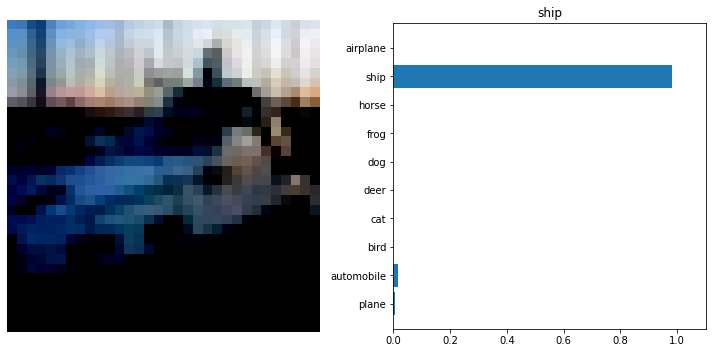

In [31]:
for batch_idx, (inputs, labels) in enumerate(test_loader):
  inputs, labels = inputs.to(device), labels.to(device)
  img = inputs[2]
  label_true = labels[2]
  ps = model_1(inputs)
  Classifier(img.cpu(), torch.softmax(ps[2].cpu(), dim=0), classes[int(label_true.cpu().numpy())])
  
  break